Reference: https://github.com/thiagodma/Pytorch_exs/blob/master/MultiTaskLearning/multitask_age_gender_ethnicity_resnet34.ipynb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import torch
import numpy as np

In [3]:
from UTKFace_train_utils import get_df_files, get_image_databunch, get_gen_acc

In [4]:
from fb_utils import set_device, get_dataloader, get_pytorch_model, get_foolbox_model

In [5]:
torch.cuda.set_device(2)
device, kwargs = set_device(device_name="cuda:2")
print(device, kwargs)
torch.cuda.empty_cache()

cuda:2 {'num_workers': 1, 'pin_memory': True}


## Creating binary dataframes

In [6]:
df_ethnicity = get_df_files(concept='ethnicity')

In [7]:
df_ethnicity.head(5)

,image_id,ethnicity,is_valid
0,UTKFace/58_0_3_20170119211544361.jpg.chip.jpg,1,False
1,UTKFace/38_0_0_20170116224644283.jpg.chip.jpg,0,False
2,UTKFace/18_1_0_20170109214216731.jpg.chip.jpg,0,False
3,UTKFace/32_1_3_20170109142352309.jpg.chip.jpg,1,False
4,UTKFace/26_1_0_20170117153211341.jpg.chip.jpg,0,False


## Creating Dataset, dataloader and databunch

In [6]:
data_ethnicity = get_image_databunch(df_ethnicity)

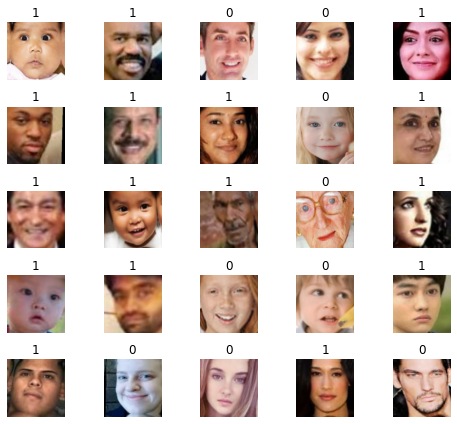

In [7]:
data_ethnicity.show_batch(rows=5, figsize=(7,6))

## Create Models

In [8]:
learn_ethnicity = cnn_learner(data_ethnicity, models.resnet50, metrics=accuracy, callback_fns=ShowGraph)
learn_ethnicity.freeze()

In [18]:
learn_ethnicity.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


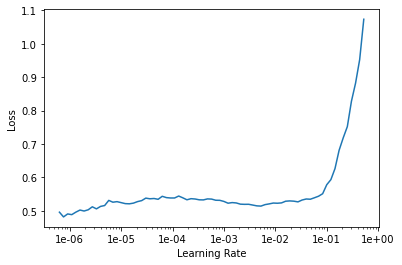

In [19]:
learn_ethnicity.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.463498,0.360462,0.838408,01:46
1,0.370273,0.295072,0.873689,01:46
2,0.301470,0.250438,0.895598,01:46
3,0.274413,0.212557,0.914524,01:46
4,0.252654,0.222218,0.909278,01:47
5,0.222186,0.187967,0.925530,01:46
6,0.212083,0.170349,0.933553,01:46
7,0.199715,0.167832,0.935610,01:46
8,0.186458,0.151928,0.941884,01:47
9,0.184113,0.135446,0.948262,01:46


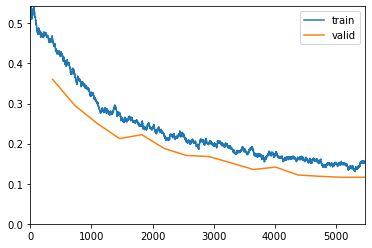

Better model found at epoch 0 with valid_loss value: 0.36046159267425537.
Better model found at epoch 1 with valid_loss value: 0.29507243633270264.
Better model found at epoch 2 with valid_loss value: 0.25043830275535583.
Better model found at epoch 3 with valid_loss value: 0.21255658566951752.
Better model found at epoch 5 with valid_loss value: 0.18796677887439728.
Better model found at epoch 6 with valid_loss value: 0.17034928500652313.
Better model found at epoch 7 with valid_loss value: 0.16783224046230316.
Better model found at epoch 8 with valid_loss value: 0.15192817151546478.
Better model found at epoch 9 with valid_loss value: 0.13544616103172302.
Better model found at epoch 11 with valid_loss value: 0.12176091969013214.
Better model found at epoch 12 with valid_loss value: 0.11833935976028442.
Better model found at epoch 13 with valid_loss value: 0.11598477512598038.


In [20]:
learn_ethnicity.fit_one_cycle(15,max_lr=1e-3, callbacks=[callbacks.SaveModelCallback(learn_ethnicity, 
                                                                                  every='improvement', 
                                                                                  monitor='valid_loss', 
                                                                                  name='stage-1-ethnicity')])

In [22]:
learn_ethnicity.load("stage-1-ethnicity")
learn_ethnicity.unfreeze()

In [23]:
learn_ethnicity.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


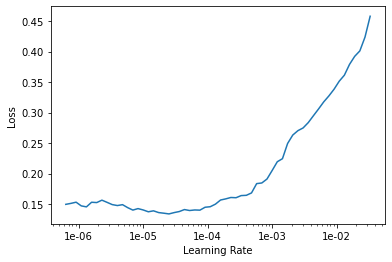

In [24]:
learn_ethnicity.recorder.plot()

In [25]:
learn_ethnicity.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


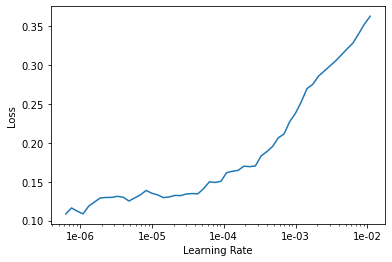

In [26]:
learn_ethnicity.recorder.plot()

In [27]:
learn_ethnicity.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.156433,0.112831,0.958856,02:18
1,0.142944,0.112182,0.959473,02:21
2,0.146024,0.110332,0.960193,02:21
3,0.145863,0.108845,0.960811,02:21
4,0.140341,0.105229,0.961839,02:21
5,0.137078,0.102814,0.963691,02:21
6,0.143372,0.096551,0.965851,02:21
7,0.139006,0.090972,0.968319,02:21
8,0.123953,0.089209,0.968216,02:21
9,0.132405,0.084036,0.969348,02:21


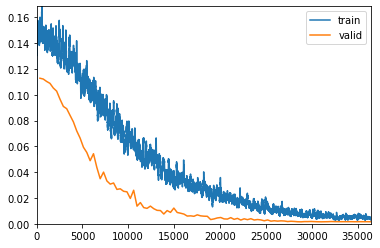

Better model found at epoch 0 with valid_loss value: 0.11283078789710999.
Better model found at epoch 1 with valid_loss value: 0.11218206584453583.
Better model found at epoch 2 with valid_loss value: 0.1103324368596077.
Better model found at epoch 3 with valid_loss value: 0.10884536802768707.
Better model found at epoch 4 with valid_loss value: 0.10522940754890442.
Better model found at epoch 5 with valid_loss value: 0.10281378030776978.
Better model found at epoch 6 with valid_loss value: 0.09655074030160904.
Better model found at epoch 7 with valid_loss value: 0.09097230434417725.
Better model found at epoch 8 with valid_loss value: 0.08920903503894806.
Better model found at epoch 9 with valid_loss value: 0.0840364545583725.
Better model found at epoch 10 with valid_loss value: 0.0789673775434494.
Better model found at epoch 11 with valid_loss value: 0.07194837927818298.
Better model found at epoch 12 with valid_loss value: 0.06645575165748596.
Better model found at epoch 13 with va

In [28]:
learn_ethnicity.fit_one_cycle(100, max_lr=slice(1e-6,3e-4), 
                           callbacks=[callbacks.SaveModelCallback(learn_ethnicity, 
                                                                  every='improvement', 
                                                                  monitor='valid_loss', 
                                                                  name='stage-2-ethnicity')])

In [29]:
learn_ethnicity.save('stage-2-rn50-ethnicity-utk')

## Calculate accuracy

In [31]:
model_ethnicity = get_pytorch_model(weights_dir = 'models', 
                                    weights_file = 'stage-2-rn50-ethnicity-utk.pth', 
                                    is_torch = False, num_classes = 2)

In [9]:
df_train = pd.read_csv('df_train_UTKFace.csv')

In [10]:
df_valid = pd.read_csv('df_valid_UTKFace.csv')

In [12]:
model_ethnicity = get_pytorch_model(weights_dir = 'models', 
                                    weights_file = 'stage-2-rn50-ethnicity-utk.pth',
                                    is_torch = False, num_classes = 2)

In [13]:
model_ethnicity.eval()
print(next(model_ethnicity.parameters()).is_cuda)

True


In [45]:
valid_dl = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_valid, 
                    root_dir='', img_pkl_file=None, is_for_train=False)

valid_acc = np.round(get_gen_acc(valid_dl, model_ethnicity, concept_index=2)/len(df_valid)*100, 2)

In [14]:
df_valid_0 = df_valid.loc[df_valid['ethnicity'].isin([0])]

valid_dl_0 = get_dataloader(kwargs_func=kwargs, batch_size=20, 
                            pd_advx=df_valid_0, root_dir='', 
                            img_pkl_file=None, is_for_train=False)

valid_acc_0 = np.round(get_gen_acc(valid_dl_0, model_ethnicity, 
                                   concept_index=2)/len(df_valid_0)*100, 2)

In [16]:
df_valid_1 = df_valid.loc[df_valid['ethnicity'].isin([1])]

valid_dl_1 = get_dataloader(kwargs_func=kwargs, batch_size=20, 
                            pd_advx=df_valid_1, root_dir='', 
                            img_pkl_file=None, is_for_train=False)

valid_acc_1 = np.round(get_gen_acc(valid_dl_1, model_ethnicity, 
                                   concept_index=2)/len(df_valid_1)*100, 2)

In [46]:
print(f"accuracy of gender model on validation data: {valid_acc}%")

accuracy of gender model on validation data: 99.88%


In [15]:
print(f"accuracy of ethnicity model on validation data for white ethnicity: {valid_acc_0}%")

accuracy of ethnicity model on validation data for white ethnicity: 99.92%


In [17]:
print(f"accuracy of ethnicity model on validation data for non-white ethnicity: {valid_acc_1}%")

accuracy of ethnicity model on validation data for non-white ethnicity: 99.82%


In [47]:
train_dl = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_train, 
                    root_dir='', img_pkl_file=None, is_for_train=False)

train_acc = np.round(get_gen_acc(train_dl, model_ethnicity, concept_index=2)/len(df_train)*100, 2)

In [10]:
print(f"accuracy of ethnicity model on train data: {train_acc}%")

accuracy of ethnicity model on train data: 99.86%


In [9]:
_, fmodel_ethnicity = get_foolbox_model(weights_file='stage-2-rn50-ethnicity-utk.pth', 
                                        dev=device, num_classes=2, is_torch=False, 
                                        preprocess=True, models_dir='models')